In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv(r"/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv", index_col=0, parse_dates=["dt"])
df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df["LandAverageTemperature"]
df.head()

dt
1750-01-01     3.034
1750-02-01     3.083
1750-03-01     5.626
1750-04-01     8.490
1750-05-01    11.573
Name: LandAverageTemperature, dtype: float64

## Explore the Data

In [4]:
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Series name: LandAverageTemperature
Non-Null Count  Dtype  
--------------  -----  
3180 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB


In [5]:
# checking the range of the data
print(df.index.min())
print(df.index.max())

1750-01-01 00:00:00
2015-12-01 00:00:00


In [6]:
# inferring the frequency of the data (or how the time series data is spaced)
pd.infer_freq(df.index)

'MS'

i.e. the temperature was recorded at the beggining of every month

Text(0, 0.5, 'Temperature (in celsuis)')

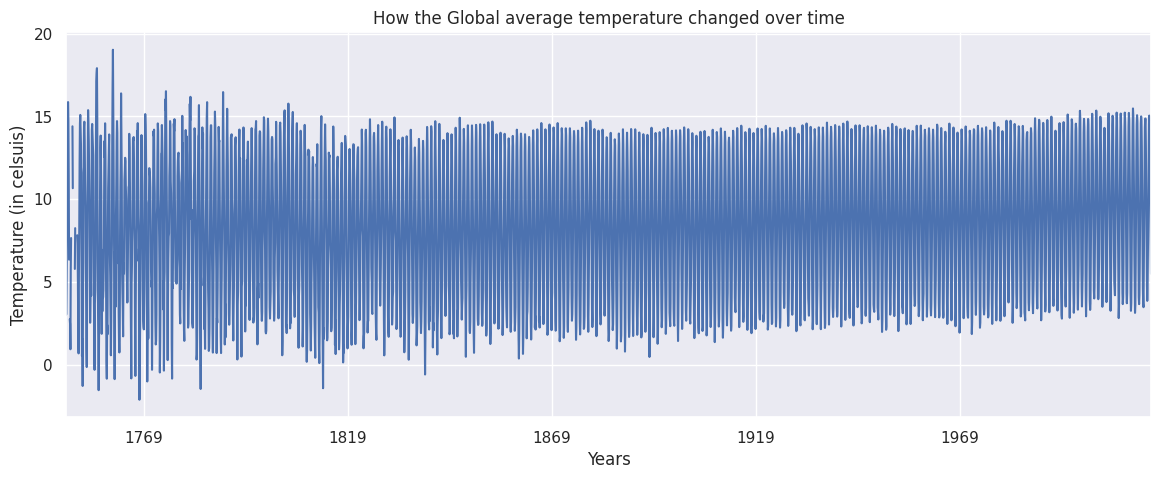

In [7]:
# visualiing the data
plt.figure(figsize=(14,5))
df.plot()
plt.title("How the Global average temperature changed over time")
plt.xlabel("Years")
plt.ylabel("Temperature (in celsuis)") # the unit was gotten from the data dictionary

Text(0, 0.5, 'Temperature (in celsuis)')

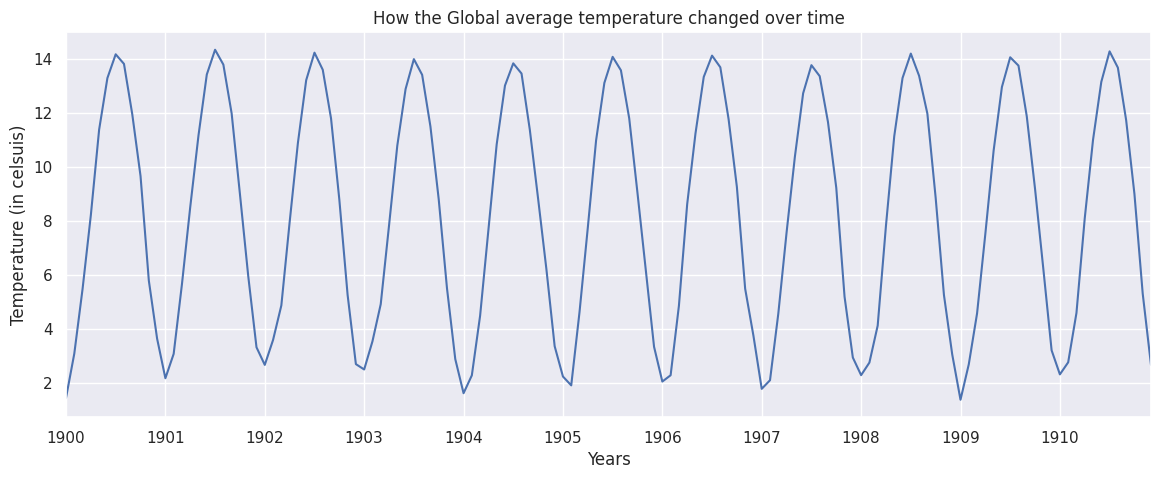

In [8]:
# getting in closer (to just 10 years of data)
plt.figure(figsize=(14,5))
df.loc["1900":"1910"].plot()
plt.title("How the Global average temperature changed over time")
plt.xlabel("Years")
plt.ylabel("Temperature (in celsuis)") # the unit was gotten from the data dictionary

In [9]:
df.describe()

count    3180.000000
mean        8.374731
std         4.381310
min        -2.080000
25%         4.312000
50%         8.610500
75%        12.548250
max        19.021000
Name: LandAverageTemperature, dtype: float64

In [10]:
# checking for missing values
df.isnull().sum()

12

In [11]:
# interpolation is a good method of filling missing values in 
# interpolation 
df = df.interpolate(method="time")

In [12]:
df.isnull().sum()

0

Text(0.5, 0, 'Global Temperatures')

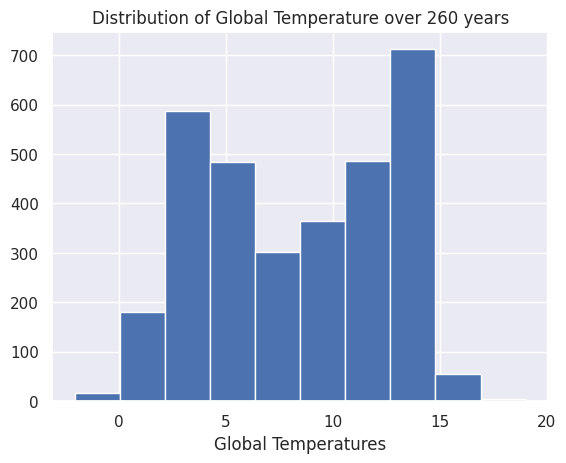

In [13]:
# checking for outliers and the overall distribution of the data
df.hist()
plt.title("Distribution of Global Temperature over 260 years")
plt.xlabel("Global Temperatures")

In [14]:
train, test = train_test_split(df, shuffle=False)

In [15]:
train.head()

dt
1750-01-01     3.034
1750-02-01     3.083
1750-03-01     5.626
1750-04-01     8.490
1750-05-01    11.573
Name: LandAverageTemperature, dtype: float64

In [16]:
train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2394 entries, 1750-01-01 to 1949-06-01
Series name: LandAverageTemperature
Non-Null Count  Dtype  
--------------  -----  
2394 non-null   float64
dtypes: float64(1)
memory usage: 37.4 KB


In [17]:
test.head()

dt
1949-07-01    14.199
1949-08-01    13.826
1949-09-01    11.957
1949-10-01     9.531
1949-11-01     6.148
Name: LandAverageTemperature, dtype: float64

In [18]:
test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 798 entries, 1949-07-01 to 2015-12-01
Series name: LandAverageTemperature
Non-Null Count  Dtype  
--------------  -----  
798 non-null    float64
dtypes: float64(1)
memory usage: 12.5 KB


## Check for Stationarity of the time series data
A data is stationary when its statistics properties like mean and variance do not change over time

### ACF and PACF plots
ACF is the correlation of the time series data with its lags

While PACF is the correlation of the time sereis with its lags after you've removed the effect of the other lags (not sure if I explained it well)

Text(0.5, 1.0, 'Parital Autocorrelation Function (ACF) on Original data')

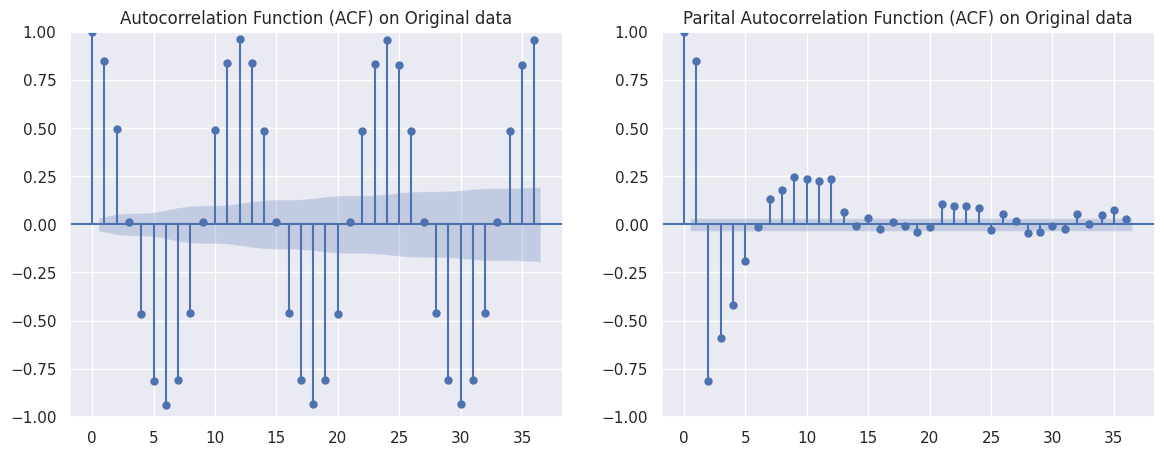

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(df, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) on Original data')

# PACF plot
plot_pacf(df, ax=axes[1])
axes[1].set_title('Parital Autocorrelation Function (ACF) on Original data')

From the Images above we can see that the data has a strong seasonal component to it.
And it is not stationary

### ADF tests

In [20]:
# null hypothesis is that there's a unit root (non-stationary)
# Alternative hypothesis is that the series is stationary or trend stationary
result = adfuller(df)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
        print("Reject the null hypothesis that the series is non-stationary (The series is most likely stationary)")
else:
    print("Do not reject the null hypothesis (The series is non-stationary)")

ADF Statistic: -4.033237906911778
p-value: 0.0012461268940846305
Reject the null hypothesis that the series is non-stationary (The series is most likely stationary)


### Seasonal Decomposition

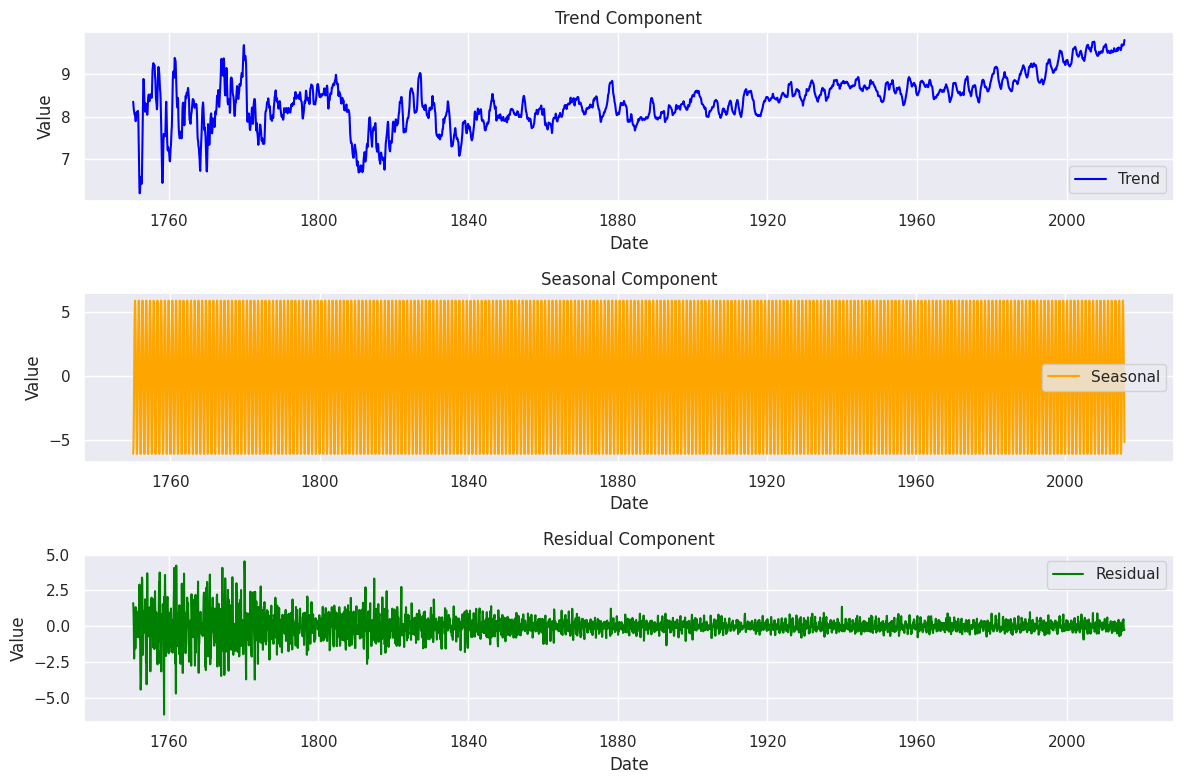

In [21]:
decomposition = seasonal_decompose(df)
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid


# Plotting each component individually
plt.figure(figsize=(12, 8))

# Plot Trend
plt.subplot(3, 1, 1)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Plot Seasonal
plt.subplot(3, 1, 2)
plt.plot(seasonal, label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Plot Residual
plt.subplot(3, 1, 3)
plt.plot(residuals, label='Residual', color='green')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

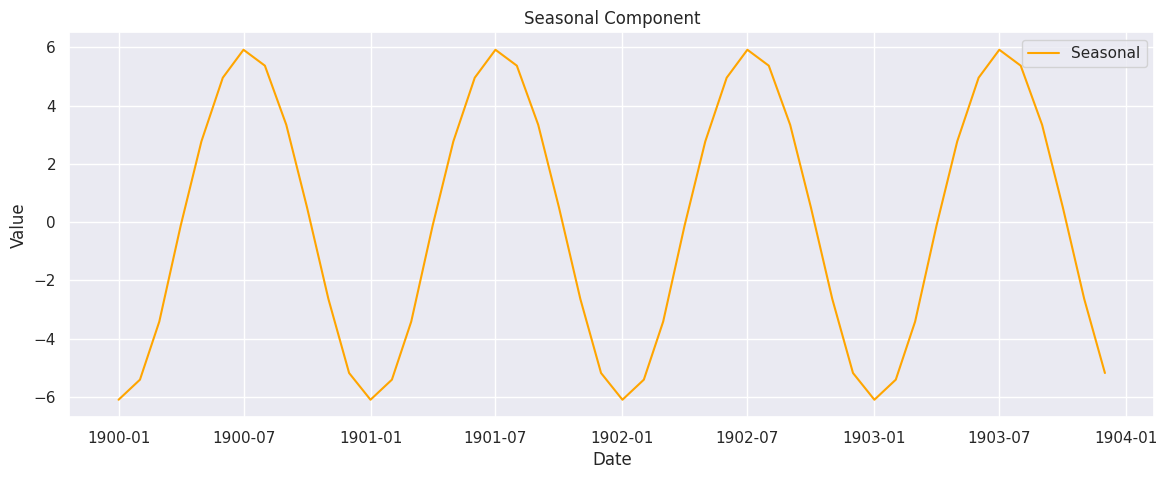

In [22]:
# Coming closer on the seasonal components
plt.figure(figsize=(14,5))
plt.plot(seasonal.loc["1900":"1903"], label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

While the trend is constand for most of the data, it starts going upwards, especially after the 1960s, there's also a strong seasonal component to it, it indicates that it has a yearly pattern to it. Also there seems to be a high variation in the residuals in early years indicating that there seems to be some data that was not been captured by the trend and seasonal components in those years

Text(0, 0.5, 'Temperature (in celsuis)')

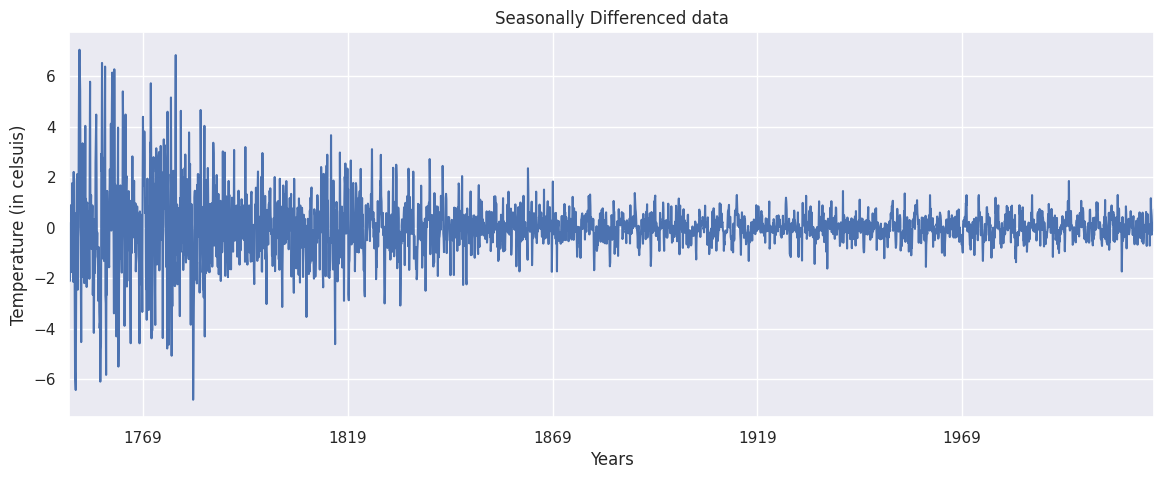

In [23]:
# since there seems to be a strong seasonal component I'm going to apply a seasonal differencing to it to assess how it'll change the data
df_seasonal_diff = df.diff(12).dropna() # 12 because of the yearly pattern (the data is collected monthly)
plt.figure(figsize=(14,5))
df_seasonal_diff.plot()
plt.title("Seasonally Differenced data")
plt.xlabel("Years")
plt.ylabel("Temperature (in celsuis)")

Text(0.5, 1.0, 'Parital Autocorrelation Function (ACF) on Seasonally differenced data')

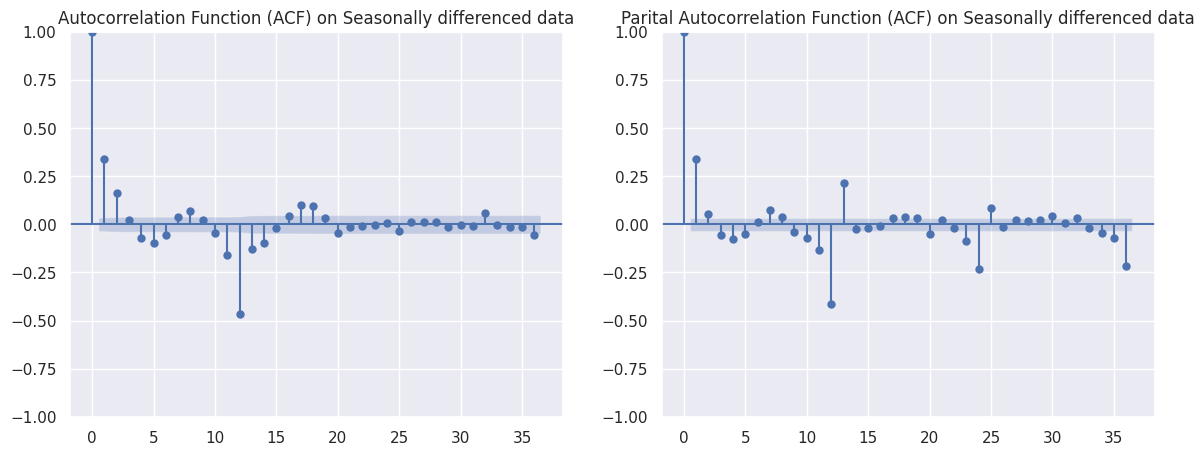

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(df_seasonal_diff, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) on Seasonally differenced data')

# PACF plot
plot_pacf(df_seasonal_diff, ax=axes[1])
axes[1].set_title('Parital Autocorrelation Function (ACF) on Seasonally differenced data')

## Selecting p, d, q
Here p would be 1 due to the fact that there's a significant spike at lag 1 and a dip in the pacf plot

d would be 1 since there is an upward trend as indicated in the seasonal decomposition

q would be 2 from the acf plot

## Training the model

In [25]:
# Step 6: Model Building and Training (SARIMAX)
model = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:               LandAverageTemperature   No. Observations:                 2394
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -3062.487
Date:                              Wed, 30 Oct 2024   AIC                           6136.974
Time:                                      11:36:42   BIC                           6171.626
Sample:                                  01-01-1750   HQIC                          6149.586
                                       - 06-01-1949                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4228      0.037     11.420      0.000       0.350       0.495
ma.L1         -1.06

### Making Predictions

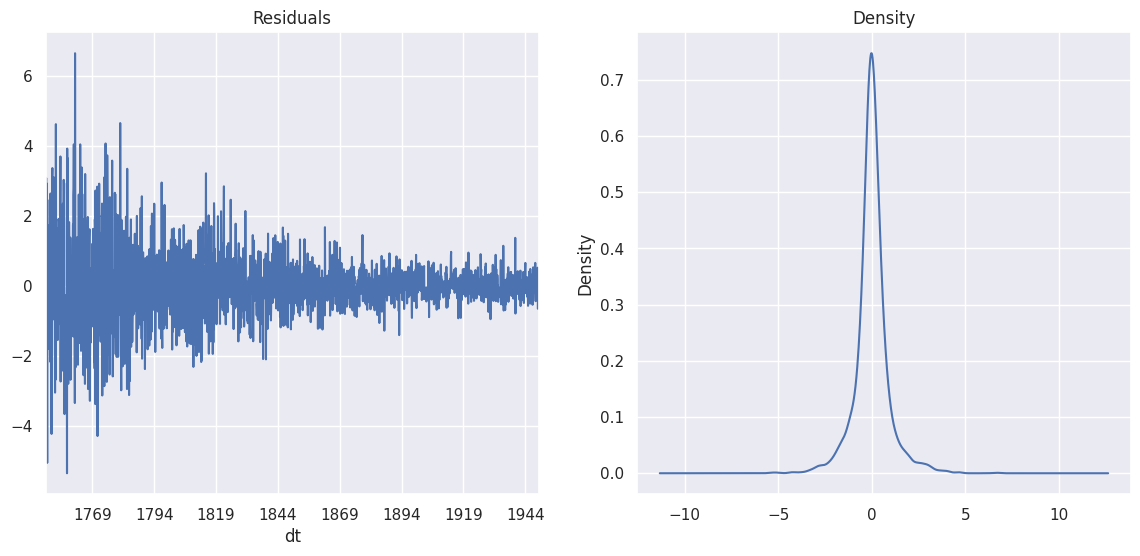

In [26]:
# plotting the residuals of the model
model_resid = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(14,6))
model_resid.plot(title="Residuals", ax=ax[0])
model_resid.plot(title="Density", kind="kde", ax=ax[1])
plt.show()

The residuals look random and its density is normally distributed with a mean of zero, which means its looking good

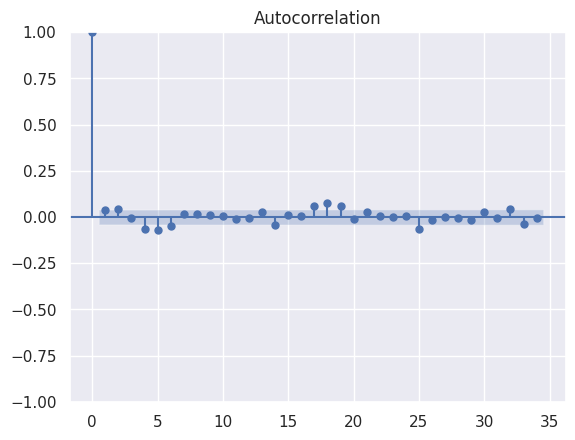

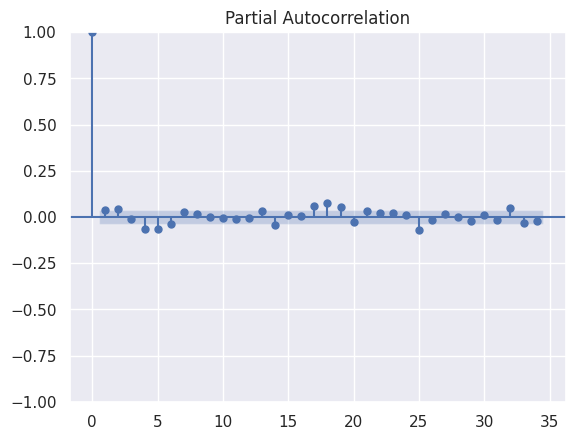

In [27]:
# plotting the acf and pacf of the residuals
acf_res = plot_acf(model_resid)
pacf_res = plot_pacf(model_resid)

<Axes: xlabel='dt'>

<Figure size 1400x500 with 0 Axes>

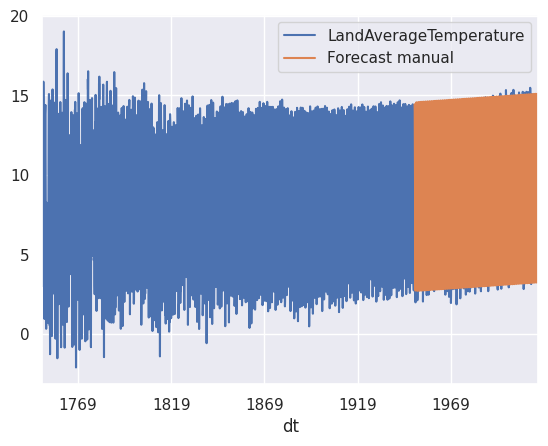

In [28]:
forecast = model_fit.forecast(len(test))
dataframe = pd.DataFrame(df)
dataframe["Forecast manual"] = [None] * len(train) + list(forecast)
plt.figure(figsize=(14, 5))
dataframe.plot()

<Axes: xlabel='dt'>

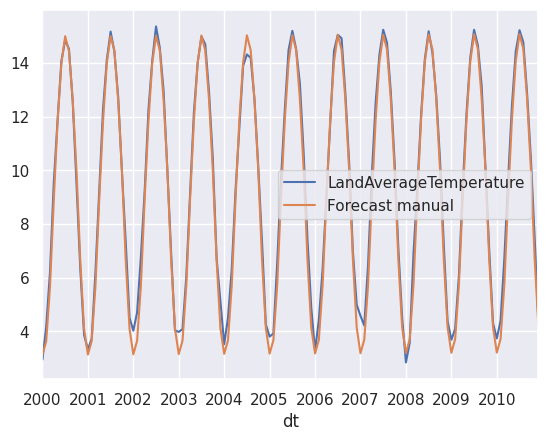

In [29]:
# Zooming in 
dataframe.loc["2000":"2010"].plot()

Not bad

## Evaluating the model

In [30]:
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"Mean absolute Error: {mae}")
print(f"Mean Absolute percentage error: {mape}")
print(f"Root mean squared error: {rmse}")

Mean absolute Error: 0.32598742373616063
Mean Absolute percentage error: 0.05157426685834112
Root mean squared error: 0.4047322145063783


It has a deviation of an average of 0.3 celsius on the test set.